RAW shapes: {'LR': (380, 380), 'HR': (1520, 1520)}
RAW ranges: {'LR': (11192.0, 19794.0), 'HR': (9265.75, 17563.0)}
Raw MAE(lr_up, hr_raw): 2991.85986328125
After TRAIN: {'lr': {'shape': (1, 1520, 1520), 'min': 10973.205078125, 'max': 19833.177734375}, 'hr': {'shape': (1, 1520, 1520), 'min': 9265.75, 'max': 17563.0}, 'MAE': 2991.85986328125}
After EVAL: {'lr': {'shape': (1, 1520, 1520), 'min': 10973.205078125, 'max': 19833.177734375}, 'hr': {'shape': (1, 1520, 1520), 'min': 9265.75, 'max': 17563.0}, 'MAE': 2991.85986328125}


C:\Users\Вячеслав\AppData\Local\Temp\ipykernel_10576\4152516971.py:59: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  lr_pil = Image.fromarray(lr_raw, mode="F")
C:\Users\Вячеслав\AppData\Local\Temp\ipykernel_10576\4152516971.py:60: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  hr_pil = Image.fromarray(hr_raw, mode="F")


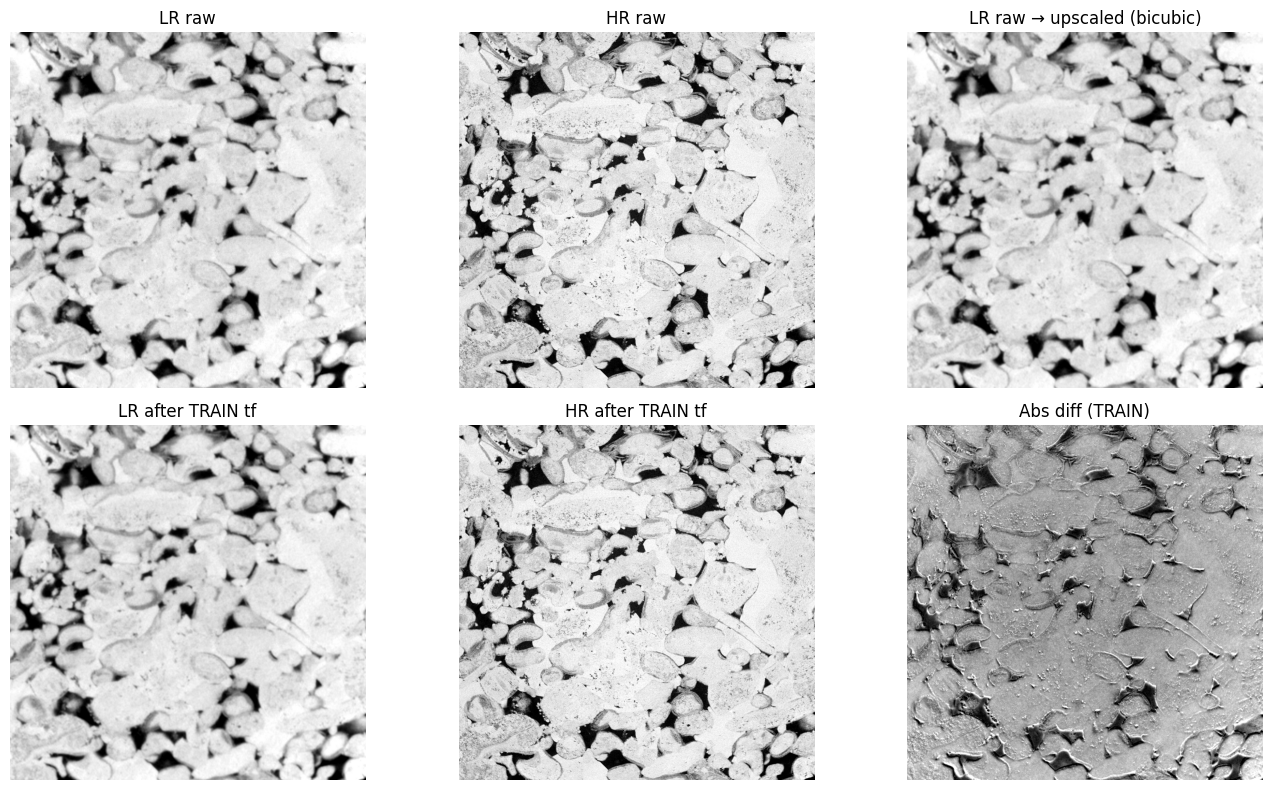

In [1]:
from pathlib import Path
import sys
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt
from sr_transforms import build_pair_transform, build_pair_transform_eval
# --- укажи одну пару ---
lr_path = Path("MRCCM2D/LR_test/block_LR_z0006.tiff")
hr_path = Path("MRCCM2D/HR_test/block_ILS1_z0006_g0006.tiff")

def read_f32(p: Path) -> np.ndarray:
    with Image.open(p) as im:
        im = im.convert("F")   # float32 TIFF
        return np.array(im, dtype=np.float32, copy=True)  # делаем копию -> writable

def show_img(ax, arr, title):
    arr = np.asarray(arr, dtype=np.float32)
    finite = np.isfinite(arr)
    if finite.any():
        p1, p99 = np.percentile(arr[finite], [1, 99])
        vmin, vmax = (p1, p99) if p99 > p1 else (arr.min(), arr.max())
    else:
        vmin, vmax = 0, 1
    ax.imshow(arr, cmap="gray", vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis("off")

def mae(a, b): 
    a = np.nan_to_num(a); b = np.nan_to_num(b)
    return float(np.mean(np.abs(a - b)))

# --- raw ---
lr_raw = read_f32(lr_path)
hr_raw = read_f32(hr_path)

print("RAW shapes:", {"LR": lr_raw.shape, "HR": hr_raw.shape})
print("RAW ranges:", {"LR": (float(np.nanmin(lr_raw)), float(np.nanmax(lr_raw))),
                      "HR": (float(np.nanmin(hr_raw)), float(np.nanmax(hr_raw)))})

# --- raw сравнение с апскейлом LR -> HR ---
lr_up = np.array(Image.fromarray(lr_raw).resize(hr_raw.shape[::-1], resample=Image.Resampling.BICUBIC),
                 dtype=np.float32, copy=True)
print("Raw MAE(lr_up, hr_raw):", mae(lr_up, hr_raw))

pair_tf_train = build_pair_transform(
    auto_gray=True,
    patch_size=None,      # без кропа — полный кадр
    do_flips=False,
    do_blur=False,
    normalize=False,
)
pair_tf_eval = build_pair_transform_eval(
    auto_gray=True,
    normalize=False,
)

# --- применяем (ожидаются PIL/tv_tensor Images) ---
lr_pil = Image.fromarray(lr_raw, mode="F")
hr_pil = Image.fromarray(hr_raw, mode="F")

lr_t_tr, hr_t_tr = pair_tf_train(lr_pil, hr_pil)  # tensors (C,H,W)
lr_t_tr = torch.nan_to_num(lr_t_tr, nan=0.0, posinf=0.0, neginf=0.0).clone()
hr_t_tr = torch.nan_to_num(hr_t_tr, nan=0.0, posinf=0.0, neginf=0.0).clone()

lr_t_ev, hr_t_ev = pair_tf_eval(lr_pil, hr_pil)
lr_t_ev = torch.nan_to_num(lr_t_ev, nan=0.0, posinf=0.0, neginf=0.0).clone()
hr_t_ev = torch.nan_to_num(hr_t_ev, nan=0.0, posinf=0.0, neginf=0.0).clone()

def tstats(x): 
    return {"shape": tuple(x.shape), "min": float(x.min()), "max": float(x.max())}

print("After TRAIN:", {"lr": tstats(lr_t_tr), "hr": tstats(hr_t_tr),
                       "MAE": float(torch.mean(torch.abs(lr_t_tr - hr_t_tr)).item())})
print("After EVAL:",  {"lr": tstats(lr_t_ev), "hr": tstats(hr_t_ev),
                       "MAE": float(torch.mean(torch.abs(lr_t_ev - hr_t_ev)).item())})

# --- визуализация ---
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
show_img(axes[0,0], lr_raw, "LR raw")
show_img(axes[0,1], hr_raw, "HR raw")
show_img(axes[0,2], lr_up,  "LR raw → upscaled (bicubic)")
show_img(axes[1,0], lr_t_tr[0].cpu().numpy(), "LR after TRAIN tf")
show_img(axes[1,1], hr_t_tr[0].cpu().numpy(), "HR after TRAIN tf")
show_img(axes[1,2], (torch.abs(lr_t_tr - hr_t_tr)[0].cpu().numpy()), "Abs diff (TRAIN)")
plt.tight_layout(); plt.show()

In [4]:
from pathlib import Path
import sys, numpy as np, torch
from PIL import Image
from sr_transforms import build_pair_transform, build_pair_transform_eval

# УКАЖИ пути
lr_path = Path("MRCCM2D/LR_test/block_LR_z0006.tiff")
hr_path = Path("MRCCM2D/HR_test/block_ILS1_z0006_g0006.tiff")

def read_f32(p: Path) -> np.ndarray:
    with Image.open(p) as im:
        im = im.convert("F")
        return np.array(im, dtype=np.float32, copy=True)

# прочитаем сырые
lr_raw = read_f32(lr_path)
hr_raw = read_f32(hr_path)
print("[RAW] LR min/max:", float(np.nanmin(lr_raw)), float(np.nanmax(lr_raw)),
      "| HR min/max:", float(np.nanmin(hr_raw)), float(np.nanmax(hr_raw)))

# подготовим PIL (ожидаемый формат для начала pipeline)
lr = Image.fromarray(lr_raw, mode="F")
hr = Image.fromarray(hr_raw, mode="F")

# собираем ТВОЙ пайплайн без кропов/аугментаций, без нормализации
pair_tf = build_pair_transform(
    auto_gray=False,
    patch_size=None,
    do_flips=False,
    do_blur=False,
    normalize=False,
)

# Попробуем получить список стадий из PairCompose:
stages = None
for attr in ("stages", "transforms", "ops", "steps"):  # на случай разных имен
    if hasattr(pair_tf, attr):
        stages = getattr(pair_tf, attr)
        break

if stages is None or not isinstance(stages, (list, tuple)):
    # Если твой PairCompose не раскрывает шаги, сделаем "грубый" прогон целиком
    print("Не удалось извлечь стадии из PairCompose; прогоняю целиком...")
    lr_t, hr_t = pair_tf(lr, hr)
    print("[ALL] lr shape:", tuple(lr_t.shape), "min/max:", float(lr_t.min()), float(lr_t.max()))
    print("[ALL] hr shape:", tuple(hr_t.shape), "min/max:", float(hr_t.min()), float(hr_t.max()))
else:
    print("Найдено стадий:", len(stages))
    cur_lr, cur_hr = lr, hr
    for i, op in enumerate(stages, 1):
        cur_lr, cur_hr = op(cur_lr, cur_hr)

        # приводим к torch.Tensor для статистик
        def to_tensor(x):
            if isinstance(x, torch.Tensor):
                t = x.clone()
            else:
                arr = np.array(x, dtype=np.float32, copy=True)
                t = torch.from_numpy(arr).unsqueeze(0)  # (1,H,W) если был 2D
            t = torch.nan_to_num(t, 0.0, 0.0, 0.0)
            return t

        tl = to_tensor(cur_lr)
        th = to_tensor(cur_hr)

        min_l, max_l = float(tl.min()), float(tl.max())
        min_h, max_h = float(th.min()), float(th.max())
        mae = float(torch.mean(torch.abs(tl - th)).item()) if tl.shape == th.shape else None

        print(f"[{i:02d}] {type(op).__name__:<28} ",
              f"LR min/max=({min_l:.6g},{max_l:.6g})",
              f"| HR min/max=({min_h:.6g},{max_h:.6g})",
              f"| MAE={mae:.6g}" if mae is not None else "")

[RAW] LR min/max: 11192.0 19794.0 | HR min/max: 9265.75 17563.0
Найдено стадий: 3
[01] PairUpscaleLRtoHR             LR min/max=(10973.2,19833.2) | HR min/max=(9265.75,17563) | MAE=2991.86
[02] PairRandomCrop                LR min/max=(10973.2,19833.2) | HR min/max=(9265.75,17563) | MAE=2991.86
[03] PairToTensor01                LR min/max=(10973.2,19833.2) | HR min/max=(9265.75,17563) | MAE=2991.86


C:\Users\Вячеслав\AppData\Local\Temp\ipykernel_5948\1909196291.py:22: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  lr = Image.fromarray(lr_raw, mode="F")
C:\Users\Вячеслав\AppData\Local\Temp\ipykernel_5948\1909196291.py:23: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  hr = Image.fromarray(hr_raw, mode="F")


RAW shapes: {'LR': (250, 250), 'HR': (500, 500)}
RAW ranges: {'LR': (10.0, 76.0), 'HR': (9.0, 77.0)}
Raw MAE(lr_up, hr_raw): 0.7868887782096863
After TRAIN: {'lr': {'shape': (1, 500, 500), 'min': 9.1824951171875, 'max': 75.89013671875}, 'hr': {'shape': (1, 500, 500), 'min': 9.0, 'max': 77.0}, 'MAE': 0.7868887782096863}
After EVAL: {'lr': {'shape': (1, 500, 500), 'min': 9.1824951171875, 'max': 75.89013671875}, 'hr': {'shape': (1, 500, 500), 'min': 9.0, 'max': 77.0}, 'MAE': 0.7868887782096863}


C:\Users\Вячеслав\AppData\Local\Temp\ipykernel_10576\3103496393.py:49: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  lr_pil = Image.fromarray(lr_raw, mode="F")
C:\Users\Вячеслав\AppData\Local\Temp\ipykernel_10576\3103496393.py:50: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  hr_pil = Image.fromarray(hr_raw, mode="F")


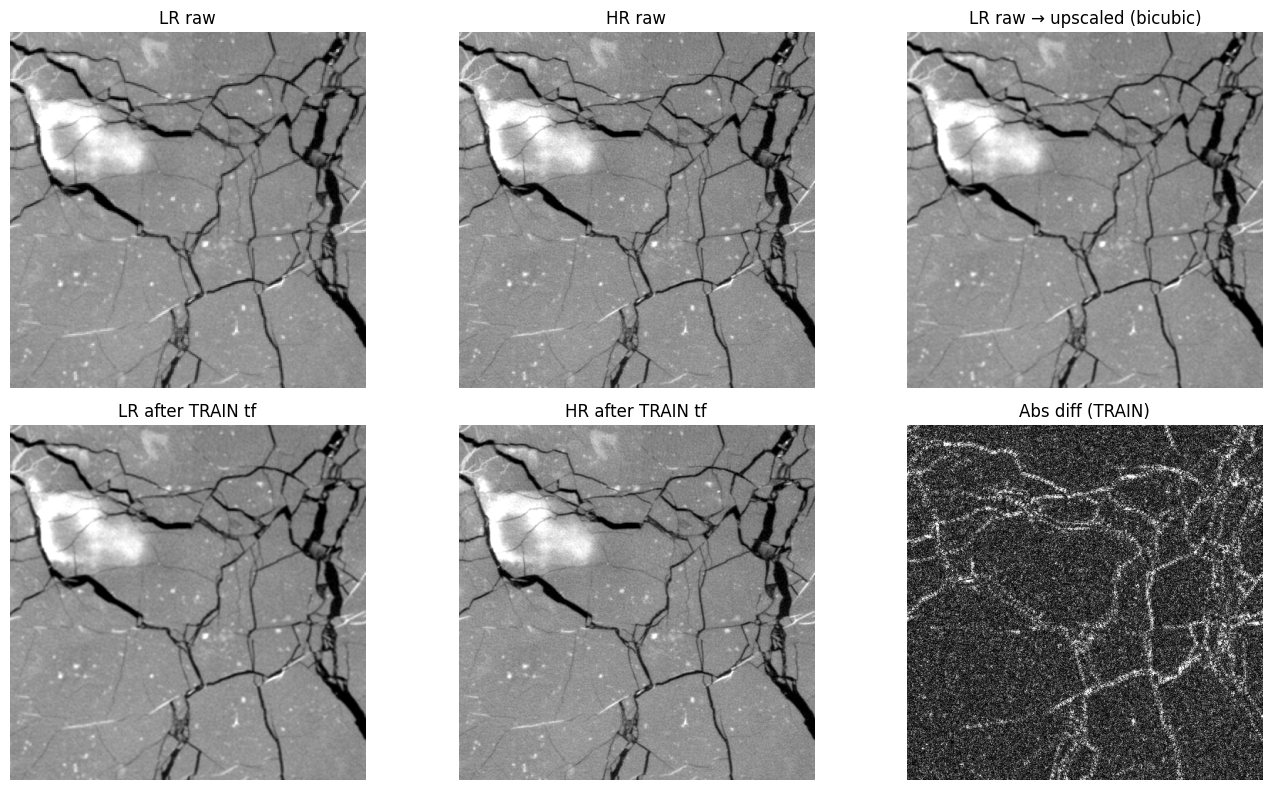

In [3]:
lr_path = Path("DeepRockSR-2D/shuffled2D/shuffled2D_train_LR_default_X2/0001x2.png")
hr_path = Path("DeepRockSR-2D/shuffled2D/shuffled2D_train_HR/0001.png")

def read_f32(p: Path) -> np.ndarray:
    with Image.open(p) as im:
        im = im.convert("F")   # float32 TIFF
        return np.array(im, dtype=np.float32, copy=True)  # делаем копию -> writable

def show_img(ax, arr, title):
    arr = np.asarray(arr, dtype=np.float32)
    finite = np.isfinite(arr)
    if finite.any():
        p1, p99 = np.percentile(arr[finite], [1, 99])
        vmin, vmax = (p1, p99) if p99 > p1 else (arr.min(), arr.max())
    else:
        vmin, vmax = 0, 1
    ax.imshow(arr, cmap="gray", vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis("off")

def mae(a, b): 
    a = np.nan_to_num(a); b = np.nan_to_num(b)
    return float(np.mean(np.abs(a - b)))

# --- raw ---
lr_raw = read_f32(lr_path)
hr_raw = read_f32(hr_path)

print("RAW shapes:", {"LR": lr_raw.shape, "HR": hr_raw.shape})
print("RAW ranges:", {"LR": (float(np.nanmin(lr_raw)), float(np.nanmax(lr_raw))),
                      "HR": (float(np.nanmin(hr_raw)), float(np.nanmax(hr_raw)))})

# --- raw сравнение с апскейлом LR -> HR ---
lr_up = np.array(Image.fromarray(lr_raw).resize(hr_raw.shape[::-1], resample=Image.Resampling.BICUBIC),
                 dtype=np.float32, copy=True)
print("Raw MAE(lr_up, hr_raw):", mae(lr_up, hr_raw))

pair_tf_train = build_pair_transform(
    patch_size=None,      # без кропа — полный кадр
    do_flips=False,
    do_blur=False,
    normalize=False,
)
pair_tf_eval = build_pair_transform_eval(
    normalize=False,
)

# --- применяем (ожидаются PIL/tv_tensor Images) ---
lr_pil = Image.fromarray(lr_raw, mode="F")
hr_pil = Image.fromarray(hr_raw, mode="F")

lr_t_tr, hr_t_tr = pair_tf_train(lr_pil, hr_pil)  # tensors (C,H,W)
lr_t_tr = torch.nan_to_num(lr_t_tr, nan=0.0, posinf=0.0, neginf=0.0).clone()
hr_t_tr = torch.nan_to_num(hr_t_tr, nan=0.0, posinf=0.0, neginf=0.0).clone()

lr_t_ev, hr_t_ev = pair_tf_eval(lr_pil, hr_pil)
lr_t_ev = torch.nan_to_num(lr_t_ev, nan=0.0, posinf=0.0, neginf=0.0).clone()
hr_t_ev = torch.nan_to_num(hr_t_ev, nan=0.0, posinf=0.0, neginf=0.0).clone()

def tstats(x): 
    return {"shape": tuple(x.shape), "min": float(x.min()), "max": float(x.max())}

print("After TRAIN:", {"lr": tstats(lr_t_tr), "hr": tstats(hr_t_tr),
                       "MAE": float(torch.mean(torch.abs(lr_t_tr - hr_t_tr)).item())})
print("After EVAL:",  {"lr": tstats(lr_t_ev), "hr": tstats(hr_t_ev),
                       "MAE": float(torch.mean(torch.abs(lr_t_ev - hr_t_ev)).item())})

# --- визуализация ---
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
show_img(axes[0,0], lr_raw, "LR raw")
show_img(axes[0,1], hr_raw, "HR raw")
show_img(axes[0,2], lr_up,  "LR raw → upscaled (bicubic)")
show_img(axes[1,0], lr_t_tr[0].cpu().numpy(), "LR after TRAIN tf")
show_img(axes[1,1], hr_t_tr[0].cpu().numpy(), "HR after TRAIN tf")
show_img(axes[1,2], (torch.abs(lr_t_tr - hr_t_tr)[0].cpu().numpy()), "Abs diff (TRAIN)")
plt.tight_layout(); plt.show()